# Alberto Casagrande 229362 NLU project 2021/2022
Implement a neural network that predicts intents and slots in a multitask learning setting. 

*   **Slot filling (Concept tagging)**: sequence labelling task in which the goal is to identify from a running dialog different slots, which correspond to different parameters of the user’s query. For instance, when a user queries for nearby restaurants, key slots for location and preferred food are required for a dialog system to retrieve the appropriate information. Thus, the main challenge in the slot-filling task is to extract the target entity. 
An example is the following: 

| Slot Filling |  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output sequence: | O  | B-depart_date.month_name | B-depart_date.day_number | O | O    | O | O      |

*   **Intent classification**: task of correctly labeling a natural language utterance from a predetermined set of intents.
An example is the following:

| Intent Classification|  |                     |                     |  |  |  |  |
|------------------|----|--------------------------|--------------------------|---|------|---|--------|
| Input sequence:  | on | april                    | first                    | I | want | a | flight |
| Output label: | flight     |


## Utils

###Import libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import os
import torch.optim as optim
import json
from pprint import pprint
import random
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
from conll import evaluate
from sklearn.metrics import classification_report, confusion_matrix

### Classification report code

In [ ]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    
    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        #print(v)
        plotMat.append(v)

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

### Confusion matrix code

In [ ]:
def plot_confusion_matrix(data, classes, size):
  cf_matrix = confusion_matrix(data[0], data[1], labels=classes)
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])

  df_cm['TOTAL'] = df_cm.sum(axis=1)
  df_cm.loc['TOTAL']= df_cm.sum()
  # get percentages
  df_percentages = df_cm.div(df_cm.TOTAL, axis=0)
  df_percentages.TOTAL = 0

  plt.figure(figsize = size)
  cmap = sn.color_palette("light:#5A9", as_cmap=True)
  sn.heatmap(df_percentages, annot=df_cm, cmap=cmap, fmt = ".0f", cbar_kws={'label': 'percentages'})

### Plot losses code

In [ ]:
def plot_losses(title, sampled_epochs, losses_train, losses_dev):
  plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, losses_train, label='Train loss')
  plt.plot(sampled_epochs, losses_dev, label='Dev loss')
  plt.legend()
  plt.show()

### Function to randomly initialize the weights
This is a generic function that randomly initialize the parameters of RNN networks and linear layers.
\
*Note: In Pytorch every parameter of the network has a proper name like weight_ih, weight_hh etc.*

In [ ]:
def init_weights(mat):
    for m in mat.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
                elif 'weight_hh' in name:
                    for idx in range(4):
                        mul = param.shape[0]//4
                        torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
                elif 'bias' in name:
                    param.data.fill_(0)
        else:
            if type(m) in [nn.Linear]:
                torch.nn.init.uniform_(m.weight, -0.01, 0.01)
                if m.bias != None:
                    m.bias.data.fill_(0.01)

## Datasets


*   **ATIS** (Airline Travel Information Systems): composed of 4978 samples in the training set and 893 samples in the test set. So, in the original split the **development set** is missing and therefore I have used a specific function to create a dev set starting from the training set. The size of the dev set is usually the 10% of the dataset. In our case, we do a stratified sampling from the training set using one or more criteria (we stratify on intents). In this way we end up having 4381 samples in the training set, 597 in the dev set and 893 in the test set. The total number of intents is 26, while the number of slot labels is 129.
Here is an example of sample taken from the dataset:

```
{
    "utterance": "on april first i need a flight going from phoenix to san diego", 
    "slots": "O B-depart_date.month_name B-depart_date.day_number O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name", 
    "intent": "flight"
}
```

*   **SNIPS**: composed of 13084 samples in the training set, 700 samples in the dev set and 700 samples in the test step. Here is an example of sample taken from the dataset:

```
{
    "utterance": "make me a reservation in south carolina",
    "slots": "O O O O O B-state I-state",
    "intent": "BookRestaurant"
}
```


In [ ]:
!git clone https://github.com/BrownFortress/IntentSlotDatasets

Cloning into 'IntentSlotDatasets'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 40 (delta 9), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
# Global variables
device = 'cuda:0' # cuda:0 means we are using the GPU with id 0, if you have multiple GPU
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # Used to report errors on CUDA side
PAD_TOKEN = 0

In [ ]:
def load_data(path):
    '''
        input: path/to/data
        output: json 
    '''
    dataset = []
    with open(path) as f:
        dataset = json.loads(f.read())
    return dataset

In [ ]:
#ATIS
tmp_train_raw_ATIS = load_data(os.path.join('data','/content/IntentSlotDatasets/ATIS','train.json'))
test_raw_ATIS = load_data(os.path.join('data','/content/IntentSlotDatasets/ATIS','test.json'))
print('Train samples:', len(tmp_train_raw_ATIS))
print('Test samples:', len(test_raw_ATIS))

pprint(tmp_train_raw_ATIS[0])

Train samples: 4978
Test samples: 893
{'intent': 'flight',
 'slots': 'O O O O O B-fromloc.city_name O B-depart_time.time '
          'I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O '
          'B-arrive_time.period_of_day',
 'utterance': 'i want to fly from boston at 838 am and arrive in denver at '
              '1110 in the morning'}


In [ ]:
#SNIPS
train_raw_SNIPS = load_data(os.path.join('data','/content/IntentSlotDatasets/SNIPS','train.json'))
dev_raw_SNIPS = load_data(os.path.join('data','/content/IntentSlotDatasets/SNIPS','valid.json'))
test_raw_SNIPS = load_data(os.path.join('data','/content/IntentSlotDatasets/SNIPS','test.json'))
print('Train samples:', len(train_raw_SNIPS))
print('Validation samples:', len(dev_raw_SNIPS))
print('Test samples:', len(test_raw_SNIPS))

pprint(train_raw_SNIPS[0])

Train samples: 13084
Validation samples: 700
Test samples: 700
{'intent': 'PlayMusic',
 'slots': 'O O B-artist O B-album O B-service I-service',
 'utterance': 'listen to westbam alumb allergic on google music'}


### Create a dev set for ATIS dataset
In the original split the developement set (dev set) is missing. To train and find the best hyperparameter of our network the dev set is fundamental. Thus, we have to create it starting from the **traning** set. The dev set is usually the 10% of the dataset. \

* Do a stratified sampling from the training set using one or more criteria.

In [ ]:
# Firt we get the 10% of dataset, then we compute the percentage of these examples 
# on the training set which is around 11% 
portion = round(((len(tmp_train_raw_ATIS) + len(test_raw_ATIS)) * 0.10)/(len(tmp_train_raw_ATIS)),2)


intents = [x['intent'] for x in tmp_train_raw_ATIS] # We stratify on intents
count_y = Counter(intents)

Y = []
X = []
mini_Train = []

for id_y, y in enumerate(intents):
    if count_y[y] > 1: # Some intents have only one instance, we put them in training
        X.append(tmp_train_raw_ATIS[id_y])
        Y.append(y)
    else:
        mini_Train.append(tmp_train_raw_ATIS[id_y])
# Random Stratify
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=portion, 
                                                    random_state=42, 
                                                    shuffle=True,
                                                    stratify=Y)
X_train.extend(mini_Train)
train_raw_ATIS = X_train
dev_raw_ATIS = X_dev

y_test = [x['intent'] for x in test_raw_ATIS]

# Intent distribution
print('Train:')
pprint({k:round(v/len(y_train),3)*100 for k, v in sorted(Counter(y_train).items())})
print('Dev:'), 
pprint({k:round(v/len(y_dev),3)*100 for k, v in sorted(Counter(y_dev).items())})
print('Test:') 
pprint({k:round(v/len(y_test),3)*100 for k, v in sorted(Counter(y_test).items())})
print('='*89)
# Dataset size
print('TRAIN size:', len(train_raw_ATIS))
print('DEV size:', len(dev_raw_ATIS))
print('TEST size:', len(test_raw_ATIS))

Train:
{'abbreviation': 2.9000000000000004,
 'aircraft': 1.6,
 'airfare': 8.5,
 'airline': 3.2,
 'airline+flight_no': 0.0,
 'airport': 0.4,
 'capacity': 0.3,
 'city': 0.4,
 'distance': 0.4,
 'flight': 73.7,
 'flight+airfare': 0.4,
 'flight_no': 0.3,
 'flight_time': 1.0999999999999999,
 'ground_fare': 0.4,
 'ground_service': 5.1,
 'meal': 0.1,
 'quantity': 1.0,
 'restriction': 0.1}
Dev:
{'abbreviation': 3.0,
 'aircraft': 1.7000000000000002,
 'airfare': 8.5,
 'airline': 3.2,
 'airport': 0.3,
 'capacity': 0.3,
 'city': 0.3,
 'distance': 0.3,
 'flight': 73.7,
 'flight+airfare': 0.5,
 'flight_no': 0.2,
 'flight_time': 1.0,
 'ground_fare': 0.3,
 'ground_service': 5.2,
 'meal': 0.2,
 'quantity': 1.0,
 'restriction': 0.2}
Test:
{'abbreviation': 3.6999999999999997,
 'aircraft': 1.0,
 'airfare': 5.4,
 'airfare+flight': 0.1,
 'airline': 4.3,
 'airport': 2.0,
 'capacity': 2.4,
 'city': 0.7000000000000001,
 'day_name': 0.2,
 'distance': 1.0999999999999999,
 'flight': 70.8,
 'flight+airfare': 1.3,
 

### Lang class
Later we will need to convert those numbers in the original form, so we need to invert those dictionaries. We create a class named as Lang just for convenience.

In [ ]:
class Lang():
    def __init__(self, words, intents, slots, cutoff=0):
        self.word2id = self.w2id(words, cutoff=cutoff, unk=True)
        self.slot2id = self.lab2id(slots)
        self.intent2id = self.lab2id(intents, pad=False)
        self.id2word = {v:k for k, v in self.word2id.items()}
        self.id2slot = {v:k for k, v in self.slot2id.items()}
        self.id2intent = {v:k for k, v in self.intent2id.items()}
        
    def w2id(self, elements, cutoff=None, unk=True):
        vocab = {'pad': PAD_TOKEN}
        if unk:
            vocab['unk'] = len(vocab)
        count = Counter(elements)
        for k, v in count.items():
            if v > cutoff:
                vocab[k] = len(vocab)
        return vocab
    
    def lab2id(self, elements, pad=True):
        vocab = {}
        if pad:
            vocab['pad'] = PAD_TOKEN
        for elem in elements:
                vocab[elem] = len(vocab)
        return vocab

In [ ]:
words_ATIS = sum([x['utterance'].split() for x in train_raw_ATIS], []) # No set() since we want to compute 
                                                            # the cutoff
corpus_ATIS = train_raw_ATIS + dev_raw_ATIS + test_raw_ATIS # We do not wat unk labels, 
                                        # however this depends on the research purpose
slots_ATIS = set(sum([line['slots'].split() for line in corpus_ATIS],[]))
intents_ATIS = set([line['intent'] for line in corpus_ATIS])

lang_ATIS = Lang(words_ATIS, intents_ATIS, slots_ATIS, cutoff=0)
print("ATIS")
print("Number of slots: ", len(slots_ATIS))
print("Number of intents: ", len(intents_ATIS))

ATIS
Number of slots:  129
Number of intents:  26


In [ ]:
words_SNIPS = sum([x['utterance'].split() for x in train_raw_SNIPS], []) # No set() since we want to compute 
                                                            # the cutoff
corpus_SNIPS = train_raw_SNIPS + dev_raw_SNIPS + test_raw_SNIPS # We do not wat unk labels, 
                                        # however this depends on the research purpose

slots_SNIPS = set(sum([line['slots'].split() for line in corpus_SNIPS],[]))
intents_SNIPS = set([line['intent'] for line in corpus_SNIPS])

lang_SNIPS = Lang(words_SNIPS, intents_SNIPS, slots_SNIPS, cutoff=0)
print("SNIPS")
print("Number of slots: ", len(slots_SNIPS))
print("Number of intents: ", len(intents_SNIPS))

SNIPS
Number of slots:  72
Number of intents:  7


In [ ]:
# Dataset analysis
intents_train_ATIS = set([line['intent'] for line in train_raw_ATIS])
intents_dev_ATIS = set([line['intent'] for line in dev_raw_ATIS])
intents_test_ATIS = set([line['intent'] for line in test_raw_ATIS])
print("ATIS ----- intents that are present in the test set but not in the train set:")
for intent in intents_test_ATIS:
  if intent not in intents_train_ATIS:
    print(intent)

ATIS ----- intents that are present in the test set but not in the train set:
flight+airline
flight_no+airline
airfare+flight
day_name


### Customize the Dataset class
In Pytorch the Dataset class helps in handling the dataset.

In [ ]:
class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, dataset, lang, unk='unk'):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk
        
        for x in dataset:
            self.utterances.append(x['utterance'])
            self.slots.append(x['slots'])
            self.intents.append(x['intent'])

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample
    
    # Auxiliary methods
    
    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]
    
    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res


In [ ]:
# Create our datasets
train_dataset_ATIS = IntentsAndSlots(train_raw_ATIS, lang_ATIS)
dev_dataset_ATIS = IntentsAndSlots(dev_raw_ATIS, lang_ATIS)
test_dataset_ATIS = IntentsAndSlots(test_raw_ATIS, lang_ATIS)

train_dataset_SNIPS = IntentsAndSlots(train_raw_SNIPS, lang_SNIPS)
dev_dataset_SNIPS = IntentsAndSlots(dev_raw_SNIPS, lang_SNIPS)
test_dataset_SNIPS = IntentsAndSlots(test_raw_SNIPS, lang_SNIPS)

### Dataset distribution

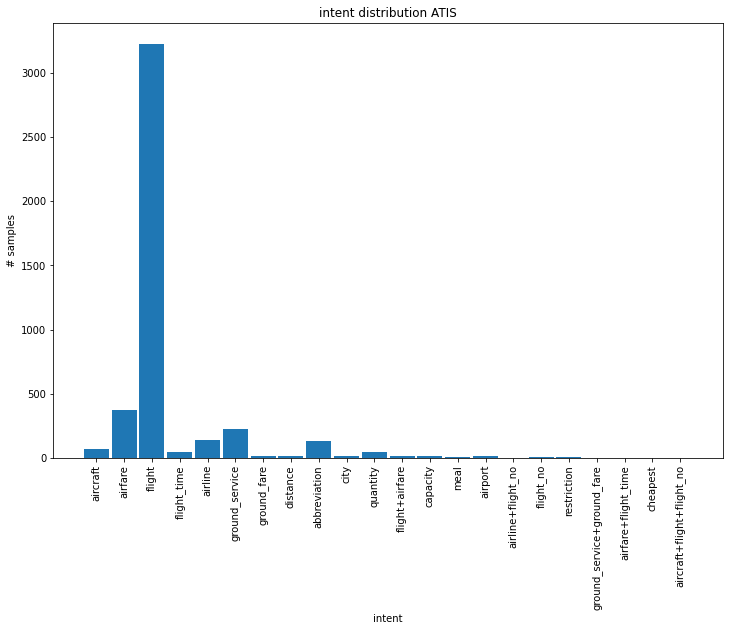

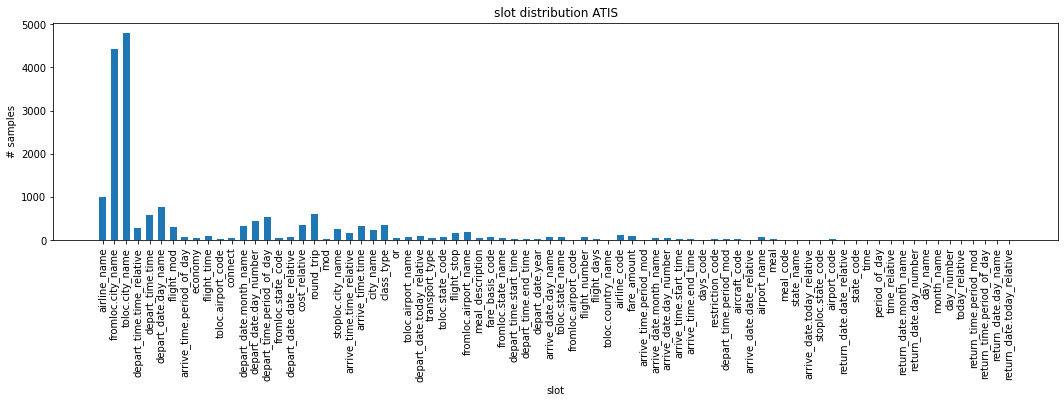

In [ ]:
labels = [line['intent'] for line in train_raw_ATIS]
classes = np.unique(labels)
plt.figure(figsize=(12,8))
plt.hist(labels, bins=np.arange(-0.5, 22), rwidth=0.9)
plt.xlabel('intent')
plt.ylabel('# samples')
plt.title('intent distribution ATIS')
plt.xticks(classes, rotation='vertical')
plt.show()

slots_labels = sum([line['slots'].split() for line in train_raw_ATIS],[])
slot_labels = []
for elem in slots_labels:
  if elem != 'O':
    slot_labels.append(elem[2:])

slots = np.unique(slot_labels)
plt.figure(figsize=(18,4))
plt.hist(slot_labels, bins=np.arange(-0.5, len(slots)), rwidth=0.6)
plt.xlabel('slot')
plt.ylabel('# samples')
plt.title('slot distribution ATIS')
plt.xticks(slots, rotation='vertical')
plt.show()

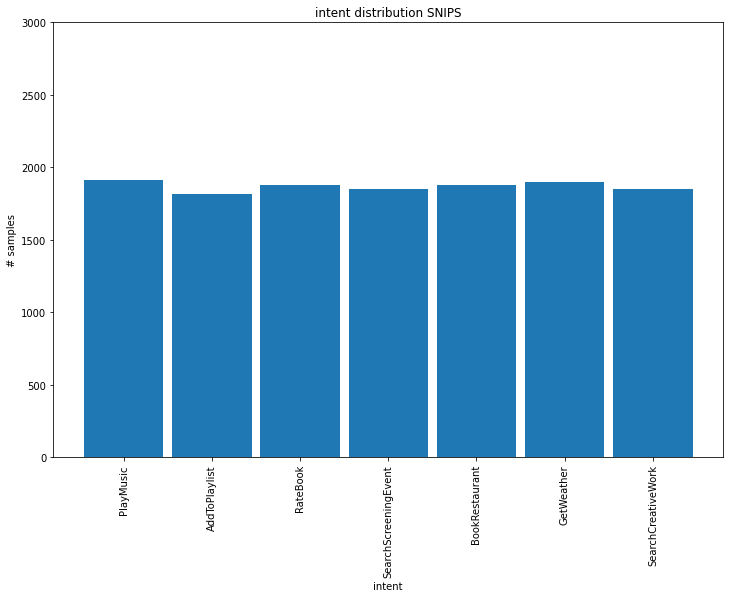

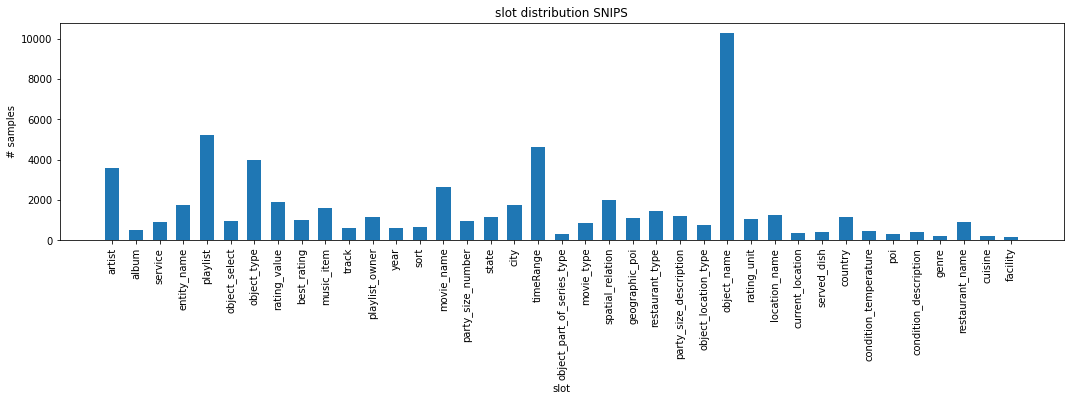

In [ ]:
labels = [line['intent'] for line in train_raw_SNIPS]
classes = np.unique(labels)
plt.figure(figsize=(12,8))
plt.hist(labels, bins=np.arange(-0.5, 7), rwidth=0.9)
plt.xlabel('intent')
plt.ylabel('# samples')
plt.title('intent distribution SNIPS')
plt.xticks(classes, rotation='vertical')
ax = plt.gca()
ax.set_ylim([0, 3000])
plt.show()

slots_labels = sum([line['slots'].split() for line in train_raw_SNIPS],[])
slot_labels = []
for elem in slots_labels:
  if elem != 'O':
    slot_labels.append(elem[2:])

slots = np.unique(slot_labels)
plt.figure(figsize=(18,4))
plt.hist(slot_labels, bins=np.arange(-0.5, len(slots)), rwidth=0.6)
plt.xlabel('slot')
plt.ylabel('# samples')
plt.title('slot distribution SNIPS')
plt.xticks(slots, rotation='vertical')
plt.show()

### Dataloader
To split the dataset into batches and add padding we will use the DataLoader class. 
```python
DataLoader(Dataset, batch_size=N, collate_fn={custom function}, shuffle=True)
```
*collate_fn* is used to shape the batch in output

In [ ]:
def collate_fn(data):
    def merge(sequences):
        '''
        merge from batch * sent_len to batch * max_len 
        '''
        lengths = [len(seq) for seq in sequences]
        max_len = 1 if max(lengths)==0 else max(lengths)
        # Pad token is zero in our case
        # So we create a matrix full of PAD_TOKEN (i.e. 0) with the shape 
        # batch_size X maximum length of a sequence
        padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(PAD_TOKEN)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq # We copy each sequence into the matrix
        # print(padded_seqs)
        padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
        return padded_seqs, lengths
    # Sort data by seq lengths
    data.sort(key=lambda x: len(x['utterance']), reverse=True) 
    new_item = {}
    for key in data[0].keys():
        new_item[key] = [d[key] for d in data]
    # We just need one length for packed pad seq, since len(utt) == len(slots)
    src_utt, _ = merge(new_item['utterance'])
    y_slots, y_lengths = merge(new_item["slots"])
    intent = torch.LongTensor(new_item["intent"])
    
    src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
    y_slots = y_slots.to(device)
    intent = intent.to(device)
    y_lengths = torch.LongTensor(y_lengths).to(device)
    
    new_item["utterances"] = src_utt
    new_item["intents"] = intent
    new_item["y_slots"] = y_slots
    new_item["slots_len"] = y_lengths
    return new_item

In [ ]:
# Dataloader instantiation
train_loader_ATIS = DataLoader(train_dataset_ATIS, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader_ATIS = DataLoader(dev_dataset_ATIS, batch_size=64, collate_fn=collate_fn)
test_loader_ATIS = DataLoader(test_dataset_ATIS, batch_size=64, collate_fn=collate_fn)

In [ ]:
# Dataloader instantiation
train_loader_SNIPS = DataLoader(train_dataset_SNIPS, batch_size=128, collate_fn=collate_fn,  shuffle=True)
dev_loader_SNIPS = DataLoader(dev_dataset_SNIPS, batch_size=64, collate_fn=collate_fn)
test_loader_SNIPS = DataLoader(test_dataset_SNIPS, batch_size=64, collate_fn=collate_fn)

##Baseline
The model for the baseline has been implemented starting from the [Lab 10](https://github.com/esrel/NLU.Lab.2022.Public/blob/master/notebooks/10_sequence_nn.ipynb).

### Definition of the structure of the neural network
The baseline model is composed of:


*   Embedding layer
*   LSTM
*   Linear layer for slots
*   Linear layer for intents



In [ ]:
class ModelIAS(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, bidirectional=False, n_layer=1, pad_index=0):
        super(ModelIAS, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)     # a simple lookup table that stores embeddings of a fixed dictionary and size
        
        self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=bidirectional)    # applies a multi-layer long short-term memory (LSTM) RNN to an input sequence
        self.slot_out = nn.Linear(2*hid_size if bidirectional else hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size
        
        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, (last_hidden, cell) = self.utt_encoder(packed_input) 
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:]
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

### Train Loop and Evaluation Loop - Baseline
We define two functions one for training our model and the other for evaluating it. To compute the performances on the slot filling task we will use the **conll script**, while for the intent classification task we are going to use the **classification_report**.

In [ ]:
def train_loop(data, optimizer, criterion_slots, criterion_intents, model, clip):
    model.train()
    loss_array = []

    for sample in data:
        optimizer.zero_grad() # Zeroing the gradient

        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])
        loss = loss_intent + loss_slot # In joint training we sum the losses

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []

    slots_pred = []
    slots_true = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:    
            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])
            loss = loss_intent + loss_slot
            
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    #tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                    slots_true.extend(gt_ids[:length])
                    slots_pred.extend(to_decode)
                hyp_slots.append(tmp_seq) 
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))
    
    cr_intents = [ref_intents, hyp_intents]
    true = [lang.id2slot[elem] for elem in slots_true]
    pred = [lang.id2slot[elem] for elem in slots_pred]
    cr_slots = [true, pred]
    report_intent = classification_report(ref_intents, hyp_intents, zero_division=False, output_dict=True)
    return results, report_intent, loss_array, cr_intents, cr_slots


### Training set up - Baseline
Here we initialize the model and we select the hyperparamters of the neural network. Futhermore, we initialize the optimizer and we select the loss function.

In [ ]:
def training_setting(bidirectional, lang, train_loader, dev_loader, test_loader):
  hid_size = 200
  emb_size = 300

  lr = 0.0001 # learning rate
  clip = 5 # Clip the gradient

  out_slot = len(lang.slot2id)
  out_int = len(lang.intent2id)
  vocab_len = len(lang.word2id)

  runs = 5
  slot_f1s, intent_acc = [], []
  for x in range(0, runs):
      model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, bidirectional, pad_index=PAD_TOKEN).to(device)
      model.apply(init_weights)
      
      optimizer = optim.Adam(model.parameters(), lr=lr)

      criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
      criterion_intents = nn.CrossEntropyLoss()
      
      n_epochs = 200
      patience = 5
      losses_train = []
      losses_dev = []
      sampled_epochs = []
      best_f1 = 0

      for x in tqdm(range(1,n_epochs)):
          loss = train_loop(train_loader, optimizer, criterion_slots, criterion_intents, model, clip)
          if x % 5 == 0:
              sampled_epochs.append(x)
              losses_train.append(np.asarray(loss).mean())
              results_dev, intent_res, loss_dev, _, _ = eval_loop(dev_loader, criterion_slots, criterion_intents, model, lang)
              losses_dev.append(np.asarray(loss_dev).mean())
              f1 = results_dev['total']['f']

              if f1 > best_f1:
                  best_f1 = f1
              else:
                  patience -= 1
              if patience <= 0: # Early stopping with patience
                  break # Not nice but it keeps the code clean

      results_test, intent_test, _, cr_intents, cr_slots = eval_loop(test_loader, criterion_slots, 
                                              criterion_intents, model, lang)
      print('Slot F1: ', results_test['total']['f'])
      print('Intent Accuracy:', intent_test['accuracy'])
      print("")
      intent_acc.append(intent_test['accuracy'])
      slot_f1s.append(results_test['total']['f'])
  slot_f1s = np.asarray(slot_f1s)
  intent_acc = np.asarray(intent_acc)
  print("")
  print('Slot F1 mean', round(slot_f1s.mean(),3))
  print('Slot F1 standard deviation', round(slot_f1s.std(),3))
  print('Intent Accuracy mean', round(intent_acc.mean(), 3))
  print('Intent Accuracy standard deviation', round(intent_acc.std(), 3))

  return sampled_epochs, losses_train, losses_dev, cr_intents, cr_slots, results_test

####ATIS

In [ ]:
sampled_epochs_ATIS, losses_train_ATIS, losses_dev_ATIS, cr_intents_ATIS, cr_slots_ATIS, results_test_ATIS  = training_setting(False, lang_ATIS, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS)

100%|██████████| 199/199 [02:35<00:00,  1.28it/s]


Slot F1:  0.9196130167106421
Intent Accuracy: 0.9451287793952967



 97%|█████████▋| 194/199 [02:32<00:03,  1.27it/s]


Slot F1:  0.9157094893090651
Intent Accuracy: 0.9316909294512878



 97%|█████████▋| 194/199 [02:32<00:03,  1.27it/s]


Slot F1:  0.9208406304728546
Intent Accuracy: 0.93505039193729



100%|██████████| 199/199 [02:35<00:00,  1.28it/s]


Slot F1:  0.9206405067745909
Intent Accuracy: 0.9372900335946248



 92%|█████████▏| 184/199 [02:24<00:11,  1.27it/s]


Slot F1:  0.9161814010940533
Intent Accuracy: 0.9417693169092946


Slot F1 mean 0.919
Slot F1 standard deviation 0.002
Intent Accuracy mean 0.938
Intent Accuracy standard deviation 0.005


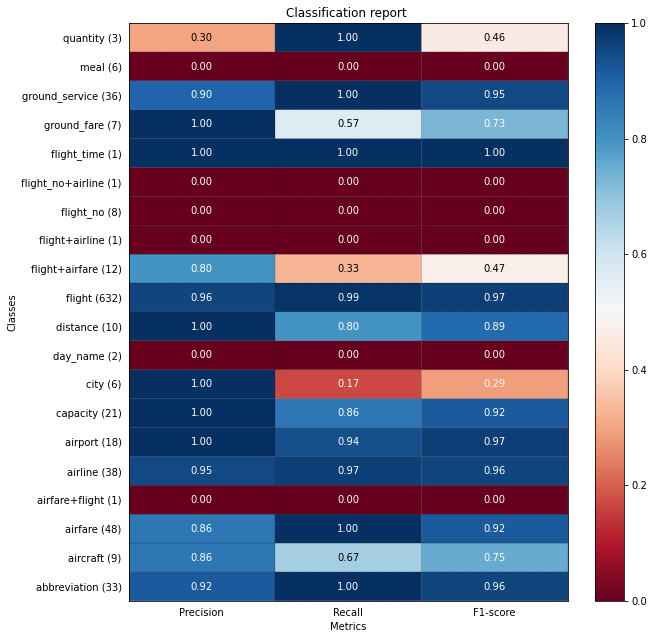

In [ ]:
#Intents
plot_classification_report(classification_report(cr_intents_ATIS[0], cr_intents_ATIS[1], zero_division=False))

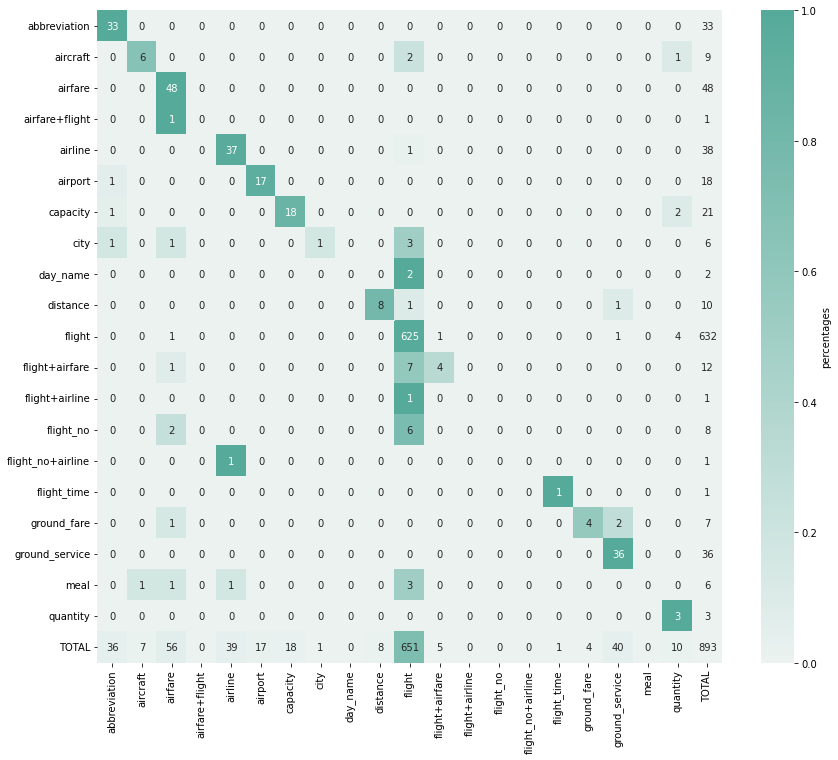

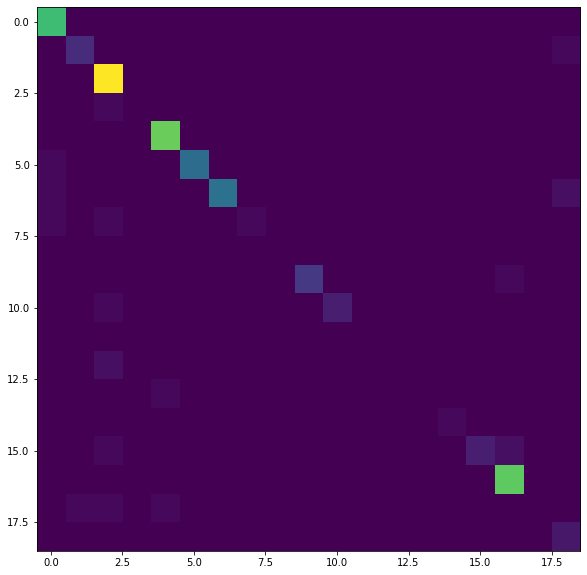

In [ ]:
labels = [line['intent'] for line in test_raw_ATIS]
classes = np.unique(labels)
size = (14,12)
plot_confusion_matrix(cr_intents_ATIS, classes, size)

plt.figure(figsize = (10,10))
classes = np.delete(classes, np.where(classes == 'flight'))
plt.imshow(confusion_matrix(cr_intents_ATIS[0], cr_intents_ATIS[1], labels=classes))
plt.show()

In [ ]:
#Slots
slots_table = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_ATIS.items(), key=lambda x: x[1]['f'], reverse = True)}, orient='index')
slots_table.round(decimals=2)

,p,r,f,s
flight_time,1.0,1.0,1.0,1
economy,1.0,1.0,1.0,6
fromloc.state_code,1.0,1.0,1.0,23
arrive_date.date_relative,1.0,1.0,1.0,2
toloc.country_name,1.0,1.0,1.0,1
...,...,...,...,...
meal_code,1.0,0.0,0.0,1
depart_date.year,1.0,0.0,0.0,3
fare_amount,0.0,0.0,0.0,2
airport_code,1.0,0.0,0.0,9


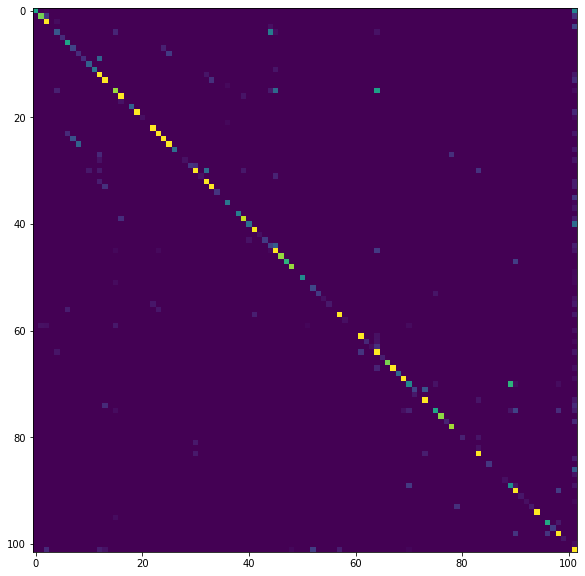

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_slots_ATIS[0], cr_slots_ATIS[1]), norm = mpl.colors.Normalize(vmin = 0, vmax = 255))
plt.show()

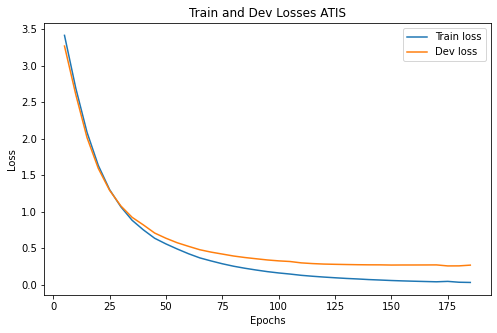

In [ ]:
title = 'Train and Dev Losses ATIS'
plot_losses(title, sampled_epochs_ATIS, losses_train_ATIS, losses_dev_ATIS)

####SNIPS

In [ ]:
sampled_epochs_SNIPS, losses_train_SNIPS, losses_dev_SNIPS, cr_intents_SNIPS, cr_slots_SNIPS, results_test_SNIPS = training_setting(False, lang_SNIPS, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS)

 67%|██████▋   | 134/199 [04:24<02:08,  1.98s/it]


Slot F1:  0.8106223175965664
Intent Accuracy: 0.9642857142857143



 60%|█████▉    | 119/199 [03:53<02:36,  1.96s/it]


Slot F1:  0.8090737240075615
Intent Accuracy: 0.9628571428571429



 67%|██████▋   | 134/199 [04:21<02:06,  1.95s/it]


Slot F1:  0.8079505774912704
Intent Accuracy: 0.9571428571428572



 67%|██████▋   | 134/199 [04:21<02:06,  1.95s/it]


Slot F1:  0.8027867095391211
Intent Accuracy: 0.9685714285714285



 77%|███████▋  | 154/199 [04:59<01:27,  1.94s/it]

Slot F1:  0.7845010615711253
Intent Accuracy: 0.9685714285714285


Slot F1 mean 0.803
Slot F1 standard deviation 0.01
Intent Accuracy mean 0.964
Intent Accuracy standard deviation 0.004


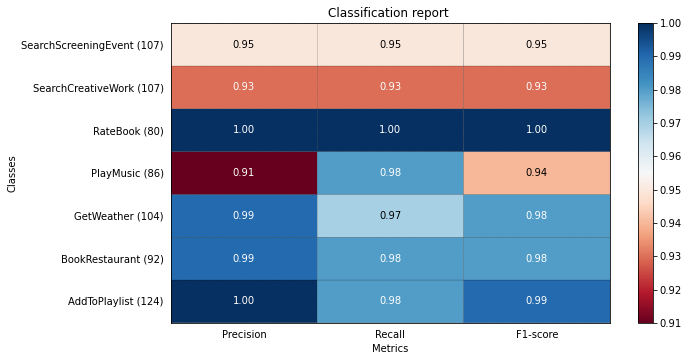

In [ ]:
#Intents
plot_classification_report(classification_report(cr_intents_SNIPS[0], cr_intents_SNIPS[1], zero_division=False))

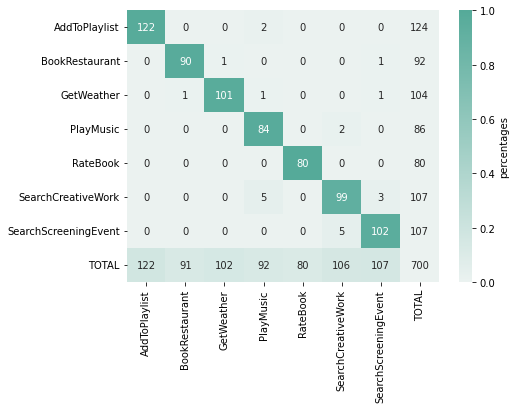

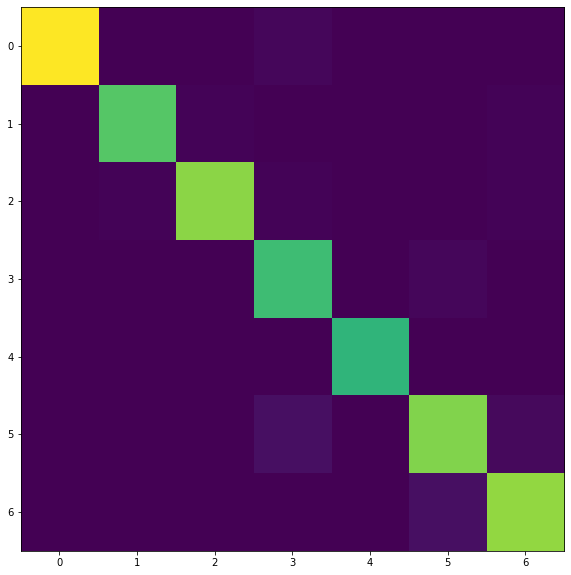

In [ ]:
labels = [line['intent'] for line in test_raw_SNIPS]
classes = np.unique(labels)
size = (7,5)
plot_confusion_matrix(cr_intents_SNIPS, classes, size)

plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_intents_SNIPS[0], cr_intents_SNIPS[1], labels=classes))
plt.show()

In [ ]:
#Slots
slots_table = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_SNIPS.items(), key=lambda x: x[1]['f'], reverse = True)}, orient='index')
slots_table.round(decimals=2)

,p,r,f,s
year,1.00,1.00,1.00,24
condition_temperature,1.00,1.00,1.00,23
facility,1.00,1.00,1.00,3
rating_unit,1.00,1.00,1.00,40
movie_type,1.00,1.00,1.00,33
best_rating,1.00,1.00,1.00,43
restaurant_type,0.98,0.95,0.97,65
music_item,0.95,0.98,0.97,104
condition_description,0.93,1.00,0.97,28
current_location,1.00,0.93,0.96,14


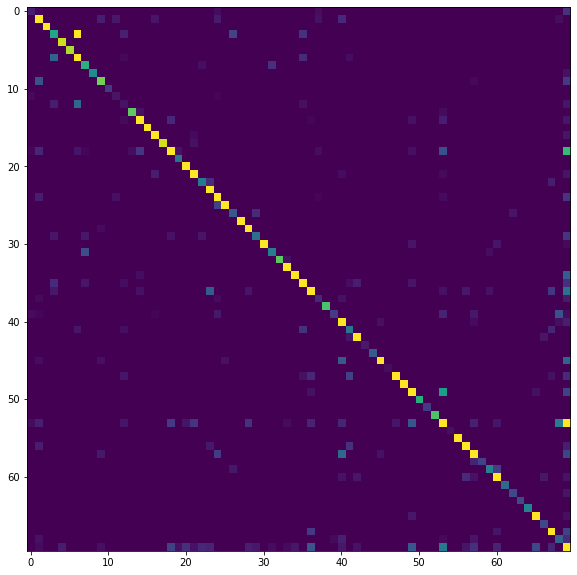

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_slots_SNIPS[0], cr_slots_SNIPS[1]), norm = mpl.colors.Normalize(vmin = 0, vmax = 255))
plt.show()

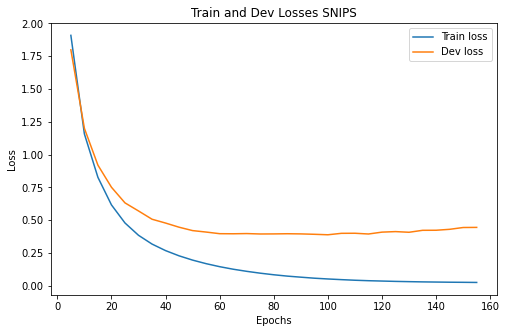

In [ ]:
title = 'Train and Dev Losses SNIPS'
plot_losses(title, sampled_epochs_SNIPS, losses_train_SNIPS, losses_dev_SNIPS)

##Second model
The second model is just a slightly modified version of the baseline model, in which it is used a **bidirectional GRU** and the value of the hidden size is 256. An attempt was also made to improve the loss function, since in the previous approach, to simultaneously learn multiple tasks it was used a naïve weighted sum of losses, where the loss weights are uniform. The new loss function is represented by the following formula:

$\mathcal{L} = \frac{1}{2σ_{1}^2}\mathcal{L}_{intent}(W) + \frac{1}{2σ_{2}^2}\mathcal{L}_{slot}(W) + log(σ_{1}) + log(σ_{2})$

It implements a sort of *dynamic loss weight learning*, where the idea is that the performance of multi-task learning systems is strongly dependent on the relative weighting between each task’s loss. 
The idea is taken from this [paper](https://arxiv.org/pdf/1705.07115v3.pdf).

In this case, the new approach weights multiple loss functions by considering the homoscedastic uncertainty of each task. This means that weightings are task-dependent and this multi-task loss function can learn to balance these weightings optimally.

In the end, judging by the results obtained with the new loss function, there were no significant improvements and therefore it was decided to keep the simple sum of the two losses.


### Definition of the structure of the neural network
The second model is composed of:


*   Embedding layer
*   Bidirectional GRU
*   Linear layer for slots
*   Linear layer for intents



In [ ]:
class ModelIAS_2(nn.Module):

    def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, bidirectional=False, n_layer=1, pad_index=0):
        super(ModelIAS_2, self).__init__()
        # hid_size = Hidden size
        # out_slot = number of slots (output size for slot filling)
        # out_int = number of intents (ouput size for intent class)
        # emb_size = word embedding size
        
        #Parameters used for implementing the dynamic loss weight learning
        self.register_parameter('log_sigma_A',torch.nn.Parameter(torch.Tensor([1])))
        self.register_parameter('log_sigma_B',torch.nn.Parameter(torch.Tensor([1])))

        self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)     # a simple lookup table that stores embeddings of a fixed dictionary and size

        self.utt_encoder = nn.GRU(emb_size, hid_size, n_layer, bidirectional=bidirectional)    # applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence
        self.slot_out = nn.Linear(2*hid_size if bidirectional else hid_size, out_slot)
        self.intent_out = nn.Linear(hid_size, out_int)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, utterance, seq_lengths):
        # utterance.size() = batch_size X seq_len
        utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
        utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size

        # pack_padded_sequence avoid computation over pad tokens reducing the computational cost
        packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
        # Process the batch
        packed_output, last_hidden = self.utt_encoder(packed_input)
        # Unpack the sequence
        utt_encoded, input_sizes = pad_packed_sequence(packed_output)
        # Get the last hidden state
        last_hidden = last_hidden[-1,:,:] 
        # Compute slot logits
        slots = self.slot_out(utt_encoded)
        # Compute intent logits
        intent = self.intent_out(last_hidden)
        
        # Slot size: seq_len, batch size, calsses 
        slots = slots.permute(1,2,0) # We need this for computing the loss
        # Slot size: batch_size, classes, seq_len
        return slots, intent

### Train Loop and Evaluation Loop - Second model
We define two functions one for training our model and the other for evaluating it. To compute the performances on the slot filling task we will use the **conll script**, while for the intent classification task we are going to use the **classification_report**.

In [ ]:
def train_loop(data, optimizer, criterion_slots, criterion_intents, model, clip, loss_weights):
    model.train()
    loss_array = []

    for sample in data:
        #log_sigma_A = loss_weights[0].cuda()
        #log_sigma_B = loss_weights[1].cuda()
        #sigma_A = torch.Tensor.exp(log_sigma_A)
        #sigma_B = torch.Tensor.exp(log_sigma_B)

        optimizer.zero_grad() # Zeroing the gradient

        slots, intent = model(sample['utterances'], sample['slots_len'])
        loss_intent = criterion_intents(intent, sample['intents'])
        loss_slot = criterion_slots(slots, sample['y_slots'])

        loss = loss_intent + loss_slot
        #loss = (1/(2*sigma_A*sigma_A)) * loss_intent + (1/(2*sigma_B*sigma_B)) * loss_slot + log_sigma_A + log_sigma_B  # dynamic loss weight learning 

        loss_array.append(loss.item())
        loss.backward() # Compute the gradient, deleting the computational graph
        # clip the gradient to avoid explosioning gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  
        optimizer.step() # Update the weights
    return loss_array

def eval_loop(data, criterion_slots, criterion_intents, model, lang, loss_weights):
    model.eval()
    loss_array = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []

    slots_pred = []
    slots_true = []
    #softmax = nn.Softmax(dim=1) # Use Softmax if you need the actual probability
    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            #log_sigma_A = loss_weights[0].cuda()
            #log_sigma_B = loss_weights[1].cuda()
            #sigma_A = torch.Tensor.exp(log_sigma_A)
            #sigma_B = torch.Tensor.exp(log_sigma_B)

            slots, intents = model(sample['utterances'], sample['slots_len'])
            loss_intent = criterion_intents(intents, sample['intents'])
            loss_slot = criterion_slots(slots, sample['y_slots'])

            loss = loss_intent + loss_slot
            #loss = (1/(2*sigma_A)) * loss_intent + (1/(2*sigma_B)) * loss_slot + log_sigma_A + log_sigma_B
            
            loss_array.append(loss.item())
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intents, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slots, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                    #tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                    slots_true.extend(gt_ids[:length])
                    slots_pred.extend(to_decode)
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))

    cr_intents = [ref_intents, hyp_intents]
    true = [lang.id2slot[elem] for elem in slots_true]
    pred = [lang.id2slot[elem] for elem in slots_pred]
    cr_slots = [true, pred] 
    report_intent = classification_report(ref_intents, hyp_intents, zero_division=False, output_dict=True)
    return results, report_intent, loss_array, cr_intents, cr_slots


### Training set up - Second model
Here we initialize the model and we select the hyperparamters of the neural network. Futhermore, we initialize the optimizer and we select the loss function.

In [ ]:
def training_setting(bidirectional, lang, train_loader, dev_loader, test_loader):
  hid_size = 256
  emb_size = 300

  lr = 0.0001 # learning rate
  clip = 5 # Clip the gradient

  out_slot = len(lang.slot2id)
  out_int = len(lang.intent2id)
  vocab_len = len(lang.word2id)

  runs = 5
  slot_f1s, intent_acc = [], []
  for x in range(0, runs):
      model = ModelIAS_2(hid_size, out_slot, out_int, emb_size, vocab_len, bidirectional, pad_index=PAD_TOKEN).to(device)
      model.apply(init_weights)
      
      #  learnable loss weight param
      log_sigma_A = torch.tensor([1.]).requires_grad_()
      log_sigma_B = torch.tensor([1.]).requires_grad_()
      loss_weight_list = [log_sigma_A, log_sigma_B]
      #optimizer = torch.optim.Adam([
      #    {'params': model.parameters()},
      #    {'params': loss_weight_list}], lr = lr)
      
      optimizer = optim.Adam(model.parameters(), lr=lr)

      criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
      criterion_intents = nn.CrossEntropyLoss()
      
      n_epochs = 200
      patience = 5
      losses_train = []
      losses_dev = []
      sampled_epochs = []
      best_f1 = 0

      for x in tqdm(range(1,n_epochs)):
          loss = train_loop(train_loader, optimizer, criterion_slots, criterion_intents, model, clip, loss_weight_list)
          if x % 5 == 0:
              sampled_epochs.append(x)
              losses_train.append(np.asarray(loss).mean())
              results_dev, intent_res, loss_dev, _, _ = eval_loop(dev_loader, criterion_slots, criterion_intents, model, lang, loss_weight_list)
              losses_dev.append(np.asarray(loss_dev).mean())
              f1 = results_dev['total']['f']

              if f1 > best_f1:
                  best_f1 = f1
              else:
                  patience -= 1
              if patience <= 0: # Early stopping with patience
                  break # Not nice but it keeps the code clean

      results_test, intent_test, _, cr_intents, cr_slots = eval_loop(test_loader, criterion_slots, 
                                              criterion_intents, model, lang, loss_weight_list)
      print('Slot F1: ', results_test['total']['f'])
      print('Intent Accuracy:', intent_test['accuracy'])
      print("")
      intent_acc.append(intent_test['accuracy'])
      slot_f1s.append(results_test['total']['f'])
  slot_f1s = np.asarray(slot_f1s)
  intent_acc = np.asarray(intent_acc)
  print("")
  print('Slot F1 mean', round(slot_f1s.mean(),3))
  print('Slot F1 standard deviation', round(slot_f1s.std(),3))
  print('Intent Accuracy mean', round(intent_acc.mean(), 3))
  print('Intent Accuracy standard deviation', round(intent_acc.std(), 3))

  return sampled_epochs, losses_train, losses_dev, cr_intents, cr_slots, results_test 

####ATIS

In [ ]:
sampled_epochs_ATIS, losses_train_ATIS, losses_dev_ATIS, cr_intents_ATIS, cr_slots_ATIS, results_test_ATIS = training_setting(True, lang_ATIS, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS)

 62%|██████▏   | 124/199 [02:00<01:12,  1.03it/s]


Slot F1:  0.9417389764476713
Intent Accuracy: 0.9585666293393057



 60%|█████▉    | 119/199 [01:53<01:16,  1.04it/s]


Slot F1:  0.9336609336609337
Intent Accuracy: 0.9552071668533034



 75%|███████▍  | 149/199 [02:22<00:47,  1.04it/s]


Slot F1:  0.9379212486697411
Intent Accuracy: 0.9563269876819709



 57%|█████▋    | 114/199 [01:49<01:21,  1.04it/s]


Slot F1:  0.9341105811694047
Intent Accuracy: 0.9574468085106383



 62%|██████▏   | 124/199 [01:59<01:11,  1.04it/s]


Slot F1:  0.9419057739992915
Intent Accuracy: 0.9496080627099664


Slot F1 mean 0.938
Slot F1 standard deviation 0.004
Intent Accuracy mean 0.955
Intent Accuracy standard deviation 0.003


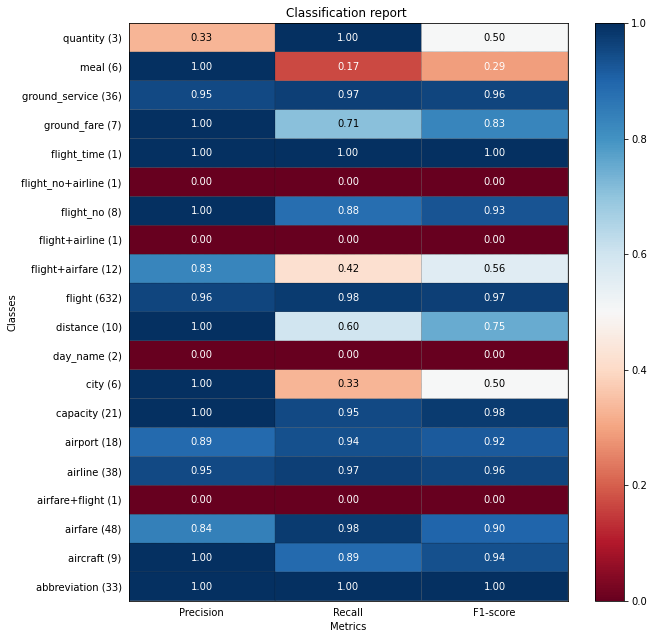

In [ ]:
#Intents
plot_classification_report(classification_report(cr_intents_ATIS[0], cr_intents_ATIS[1], zero_division=False))

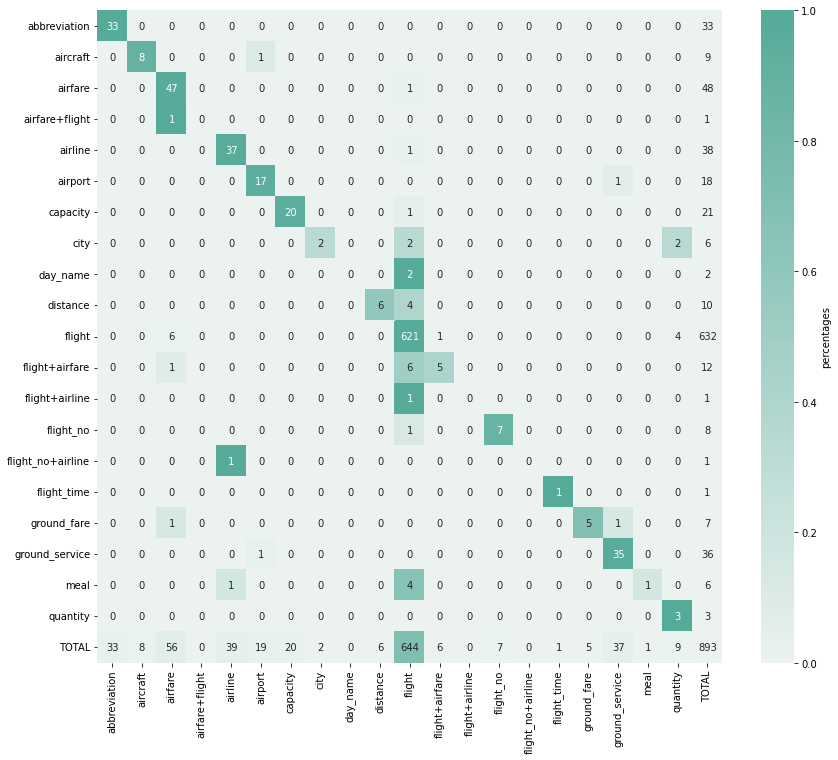

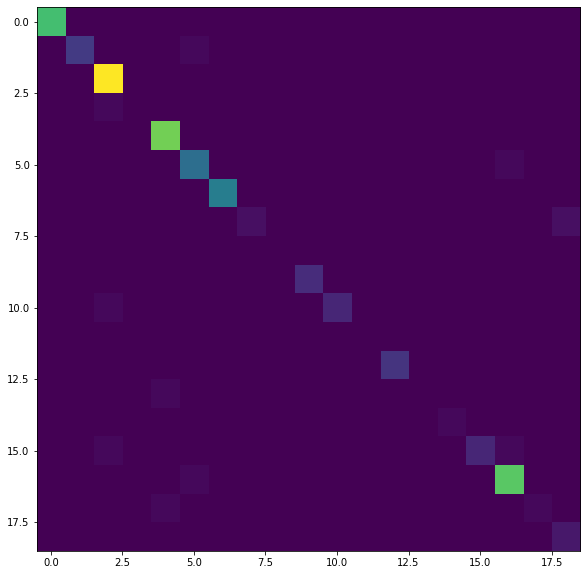

In [ ]:
labels = [line['intent'] for line in test_raw_ATIS]
classes = np.unique(labels)
size = (14,12)
plot_confusion_matrix(cr_intents_ATIS, classes, size)

plt.figure(figsize = (10,10))
classes = np.delete(classes, np.where(classes == 'flight'))
plt.imshow(confusion_matrix(cr_intents_ATIS[0], cr_intents_ATIS[1], labels=classes))
plt.show()

In [ ]:
#Slots
slots_table = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_ATIS.items(), key=lambda x: x[1]['f'], reverse = True)}, orient='index')
slots_table.round(decimals=2)

,p,r,f,s
depart_time.start_time,1.0,1.0,1.0,3
fromloc.airport_code,1.0,1.0,1.0,5
state_code,1.0,1.0,1.0,1
economy,1.0,1.0,1.0,6
connect,1.0,1.0,1.0,6
...,...,...,...,...
meal_code,1.0,0.0,0.0,1
fare_amount,0.0,0.0,0.0,2
compartment,1.0,0.0,0.0,1
airport_code,1.0,0.0,0.0,9


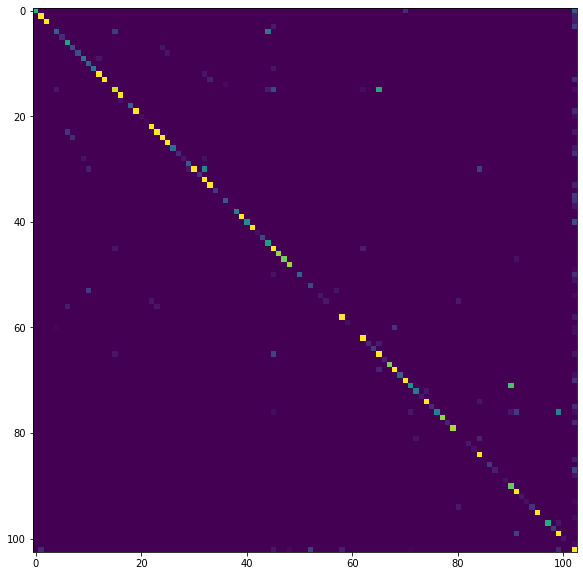

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_slots_ATIS[0], cr_slots_ATIS[1]), norm = mpl.colors.Normalize(vmin = 0, vmax = 255))
plt.show()

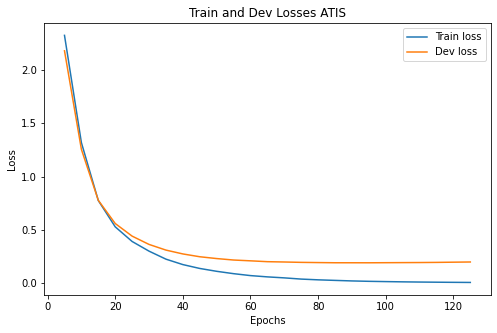

In [ ]:
title = 'Train and Dev Losses ATIS'
plot_losses(title, sampled_epochs_ATIS, losses_train_ATIS, losses_dev_ATIS)

####SNIPS

In [ ]:
sampled_epochs_SNIPS, losses_train_SNIPS, losses_dev_SNIPS, cr_intents_SNIPS, cr_slots_SNIPS, results_test_SNIPS = training_setting(True, lang_SNIPS, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS)

 47%|████▋     | 94/199 [03:50<04:17,  2.45s/it]


Slot F1:  0.8693522046815461
Intent Accuracy: 0.9685714285714285



 37%|███▋      | 74/199 [03:00<05:04,  2.44s/it]


Slot F1:  0.8468120342257797
Intent Accuracy: 0.95



 42%|████▏     | 84/199 [03:24<04:40,  2.44s/it]


Slot F1:  0.8597063621533442
Intent Accuracy: 0.9671428571428572



 50%|████▉     | 99/199 [04:01<04:03,  2.44s/it]


Slot F1:  0.8528138528138528
Intent Accuracy: 0.9671428571428572



 57%|█████▋    | 114/199 [04:37<03:26,  2.43s/it]

Slot F1:  0.8731547293603061
Intent Accuracy: 0.9728571428571429


Slot F1 mean 0.86
Slot F1 standard deviation 0.01
Intent Accuracy mean 0.965
Intent Accuracy standard deviation 0.008


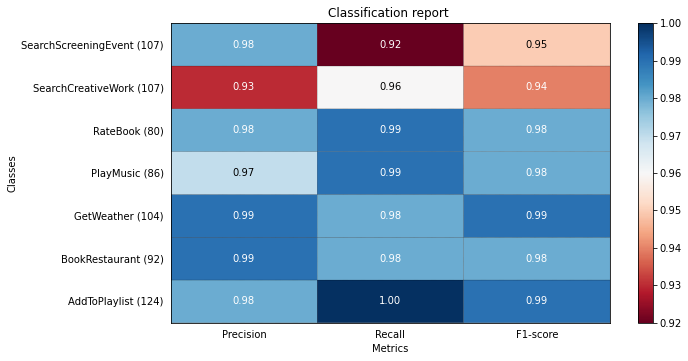

In [ ]:
plot_classification_report(classification_report(cr_intents_SNIPS[0], cr_intents_SNIPS[1], zero_division=False))

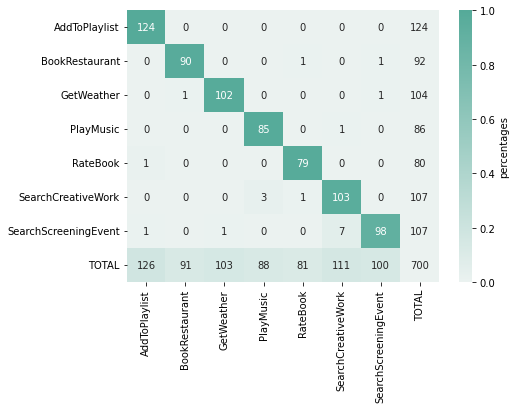

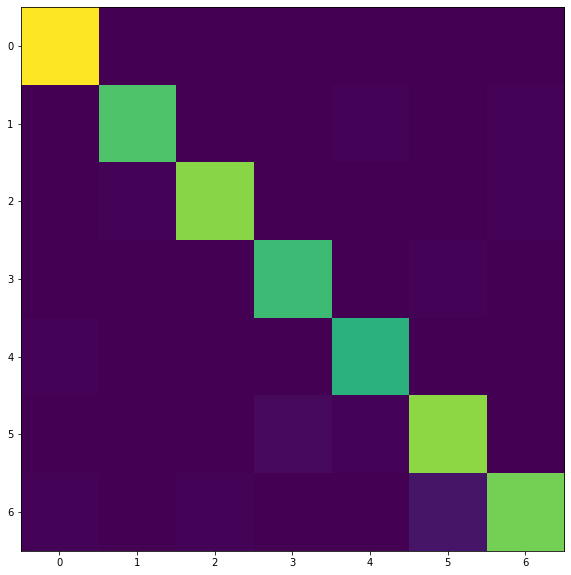

In [ ]:
labels = [line['intent'] for line in test_raw_SNIPS]
classes = np.unique(labels)
size = (7, 5)
plot_confusion_matrix(cr_intents_SNIPS, classes, size)

plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_intents_SNIPS[0], cr_intents_SNIPS[1], labels=classes))
plt.show()

In [ ]:
#Slots
slots_table = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_SNIPS.items(), key=lambda x: x[1]['f'], reverse = True)}, orient='index')
slots_table.round(decimals=2)

,p,r,f,s
condition_temperature,1.00,1.00,1.00,23
rating_unit,1.00,1.00,1.00,40
movie_type,1.00,1.00,1.00,33
best_rating,1.00,1.00,1.00,43
service,1.00,1.00,1.00,24
rating_value,1.00,1.00,1.00,80
party_size_number,0.98,1.00,0.99,50
playlist_owner,0.99,0.99,0.99,70
music_item,0.98,0.99,0.99,104
restaurant_type,1.00,0.97,0.98,65


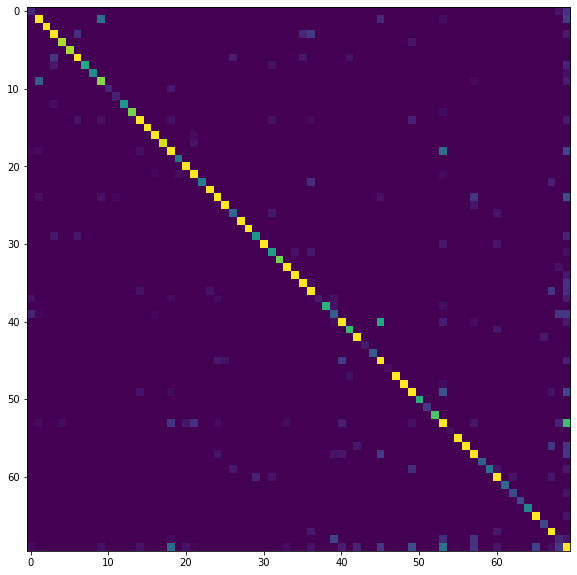

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_slots_SNIPS[0], cr_slots_SNIPS[1]), norm = mpl.colors.Normalize(vmin = 0, vmax = 255))
plt.show()

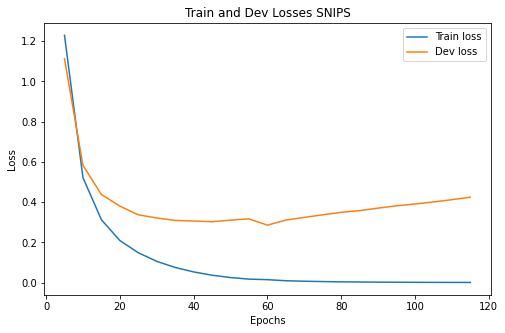

In [ ]:
title = 'Train and Dev Losses SNIPS'
plot_losses(title, sampled_epochs_SNIPS, losses_train_SNIPS, losses_dev_SNIPS)

##Third model
The third model is the implementation of the paper [A Bi-model based RNN Semantic Frame Parsing Model for Intent Detection and Slot Filling](https://arxiv.org/pdf/1812.10235.pdf). It is based on an unofficial implementation on [GitHub](https://github.com/ray075hl/Bi-Model-Intent-And-Slot). The overall structure is shown in the following figure.
<img src="https://drive.google.com/uc?export=view&id=1lIkvczUbPW0yab1wKduPISw4EN5yUQjv" width="600">

It is quite complex, as it is composed by two models - one for intent detection and the other for slot filling. Each task-network includes one BLSTM with an LSTM decoder. The basic idea of the network is to take the cross-impact between the two tasks into account. For this purpose, the two bidirectional LSTMs (BLSTMs) are inter-connected. Each BLSTM $f_{i}(\cdot)$ reads the input utterance sequences forward and backward and generates a sequence of hidden states $(h_{1}^i , h_{2}^i , \cdots , h_{n}^i)$ where $i=1$ corresponds to the network for intent classification task and $i=2$ is for the slot filling task. The peculiarity lies in the fact that, in order to detect intent, the hidden state $h_{t}^1$ is combined together with $h_{t}^2$ from the other BLSTM $f_{2}(\cdot)$ in slot filling task-network to generate the state $s_{t}^1$.
For the slot filling task, a similar network structure is considered. The biggest difference is that we have an output at each time step $t$.

The two task-networks are trained based on their own cost function in an asynchronous manner. Both loss functions $\mathcal{L}_{intent}$ and $\mathcal{L}_{slot}$ are defined using cross entropy.
This has the advantage of filtering the negative effects between the two tasks compared with using only one joint model. Furthermore, each of the two models is specialized for a single task and the cross-impact between the two tasks can be learned by sharing hidden states of the two models.


### Definition of the structure of the neural network
The third model is composed of:
* Slot filling model
  *   Slot encoder
    *   Embedding layer
    *   BLSTM

  *   Slot decoder
    *   LSTM
    *   Linear layer
* Intent classification model
  *   Intent encoder
    *   Embedding layer
    *   BLSTM
  *   Intent decoder
    *   LSTM
    *   Linear layer



In [ ]:
# Bi-model 
class slot_enc(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, vocab_size):
        super(slot_enc, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=lstm_hidden_size, num_layers=2, bidirectional=True, batch_first=True, dropout=DROPOUT)

    def forward(self, x):
        x = self.embedding(x)
        x = F.dropout(x, DROPOUT)   
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)
        return x


class slot_dec(nn.Module):
    def __init__(self, lstm_hidden_size, label_size):
        super(slot_dec, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_hidden_size*5, hidden_size=lstm_hidden_size, num_layers=1)
        self.fc = nn.Linear(lstm_hidden_size, label_size)
        self.hidden_size = lstm_hidden_size

    def forward(self, x, hi):
        batch = x.size(0)
        length = x.size(1)

        dec_init_out = torch.zeros(batch, 1, self.hidden_size).to(device)
        hidden_state = (torch.zeros(1, 1, self.hidden_size).to(device), \
                        torch.zeros(1, 1, self.hidden_size).to(device))
        x = torch.cat((x, hi), dim=-1)

        x = x.transpose(1, 0)  # 50 x batch x feature_size
        x = F.dropout(x, DROPOUT)
        all_out = []
        for i in range(length):
            if i == 0:
                out, hidden_state = self.lstm(torch.cat((x[i].unsqueeze(1), dec_init_out), dim=-1), hidden_state)
            else:
                out, hidden_state = self.lstm(torch.cat((x[i].unsqueeze(1), out), dim=-1), hidden_state)
            all_out.append(out)
        output = torch.cat(all_out, dim=1) # 50 x batch x feature_size
        x = F.dropout(x, DROPOUT)
        res = self.fc(output)
        res = res.permute(0, 2, 1)
        return res 



class intent_enc(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, vocab_size):
        super(intent_enc, self).__init__()
		
        self.embedding = nn.Embedding(vocab_size, embedding_size).to(device)
        # self.embedding.weight.data.uniform_(-1.0, 1.0)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= lstm_hidden_size, num_layers=2, bidirectional= True, batch_first=True, dropout=DROPOUT)
    
    def forward(self, x):
        x = self.embedding(x)
        x = F.dropout(x, DROPOUT)
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)
        return x


class intent_dec(nn.Module):
    def __init__(self, lstm_hidden_size, label_size):
        super(intent_dec, self).__init__()
        self.lstm = nn.LSTM(input_size=lstm_hidden_size*4, hidden_size=lstm_hidden_size, batch_first=True, num_layers=1)
        self.fc = nn.Linear(lstm_hidden_size, label_size)
        
    def forward(self, x, hs, real_len):
        batch = x.size()[0]
        real_len = real_len.to(device)
        x = torch.cat((x, hs), dim=-1)
        x = F.dropout(x, DROPOUT)
        x, _ = self.lstm(x)
        x = F.dropout(x, DROPOUT)

        index = torch.arange(batch).long().to(device)
        state = x[index, real_len-1, :]
        
        res = self.fc(state.squeeze())
        return res
        


class Intent(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, batch, max_len, vocab_len, out_int):
        super(Intent, self).__init__()
        self.enc = intent_enc(embedding_size, lstm_hidden_size, vocab_len).to(device)
        self.dec = intent_dec(lstm_hidden_size, out_int).to(device)
        self.share_memory = torch.zeros(batch, max_len, lstm_hidden_size * 2).to(device)
    

class Slot(nn.Module):
    def __init__(self, embedding_size, lstm_hidden_size, batch, max_len, vocab_len, out_slot):
        super(Slot, self).__init__()
        self.enc = slot_enc(embedding_size, lstm_hidden_size, vocab_len).to(device)
        self.dec = slot_dec(lstm_hidden_size, out_slot).to(device)
        self.share_memory = torch.zeros(batch, max_len, lstm_hidden_size * 2).to(device)

### Train Loop and Evaluation Loop - Third model
We define two functions one for training our model and the other for evaluating it. To compute the performances on the slot filling task we will use the **conll script**, while for the intent classification task we are going to use the **classification_report**.

In [ ]:
def train_loop(data, optimizer_slots, optimizer_intents, criterion_slots, criterion_intents, slot_model, intent_model, clip):
    slot_model.train()
    intent_model.train()
    slot_loss_history = []
    intent_loss_history = []

    for sample in data:

        optimizer_slots.zero_grad() # Zeroing the gradient
        optimizer_intents.zero_grad() # Zeroing the gradient

        hs = slot_model.enc(sample['utterances'])
        slot_model.share_memory = hs.clone()

        hi = intent_model.enc(sample['utterances'])
        intent_model.share_memory = hi.clone()
        
        slot_logits = slot_model.dec(hs, intent_model.share_memory.detach())
        slot_logits = F.log_softmax(slot_logits, dim=-1)
        slot_loss = criterion_slots(slot_logits, sample['y_slots'])
        slot_loss_history.append(slot_loss.item())
        slot_loss.backward()
        torch.nn.utils.clip_grad_norm_(slot_model.parameters(), clip)
        optimizer_slots.step()

        intent_logits = intent_model.dec(hi, slot_model.share_memory.detach(), sample['slots_len'])
        intent_logits = F.log_softmax(intent_logits, dim=-1)
        intent_loss = criterion_intents(intent_logits, sample['intents'])
        intent_loss_history.append(intent_loss.item())
        intent_loss.backward()
        torch.nn.utils.clip_grad_norm_(intent_model.parameters(), clip)
        optimizer_intents.step()
    return slot_loss_history, intent_loss_history

def eval_loop(data, criterion_slots, criterion_intents, slot_model, intent_model, lang):
    slot_model.eval()
    intent_model.eval()

    slot_loss_history = []
    intent_loss_history = []
    
    ref_intents = []
    hyp_intents = []
    
    ref_slots = []
    hyp_slots = []

    slots_pred = []
    slots_true = []

    with torch.no_grad(): # It used to avoid the creation of computational graph
        for sample in data:
            hs = slot_model.enc(sample['utterances'])
            slot_model.share_memory = hs.clone()

            hi = intent_model.enc(sample['utterances'])
            intent_model.share_memory = hi.clone()

            slot_logits = slot_model.dec(hs, intent_model.share_memory.detach())
            slot_logits = F.log_softmax(slot_logits, dim=-1)
            slot_loss = criterion_slots(slot_logits, sample['y_slots'])
            slot_loss_history.append(slot_loss.item())

            intent_logits = intent_model.dec(hi, slot_model.share_memory.detach(), sample['slots_len'])
            intent_logits = F.log_softmax(intent_logits, dim=-1)
            intent_loss = criterion_intents(intent_logits, sample['intents'])
            intent_loss_history.append(intent_loss.item())
            
            # Intent inference
            # Get the highest probable class
            out_intents = [lang.id2intent[x] 
                           for x in torch.argmax(intent_logits, dim=1).tolist()] 
            gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
            ref_intents.extend(gt_intents)
            hyp_intents.extend(out_intents)
            # Slot inference 
            output_slots = torch.argmax(slot_logits, dim=1)
            for id_seq, seq in enumerate(output_slots):
                length = sample['slots_len'].tolist()[id_seq]
                utt_ids = sample['utterance'][id_seq][:length].tolist()
                gt_ids = sample['y_slots'][id_seq].tolist()
                gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
                utterance = [lang.id2word[elem] for elem in utt_ids]
                to_decode = seq[:length].tolist()
                ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
                tmp_seq = []
                for id_el, elem in enumerate(to_decode):
                    #tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
                    tmp_seq.append((utterance[id_el], lang.id2slot[elem]) if elem != 0 else (utterance[id_el], 'O'))
                    slots_true.extend(gt_ids[:length])
                    slots_pred.extend(to_decode)
                hyp_slots.append(tmp_seq)
    try:            
        results = evaluate(ref_slots, hyp_slots)
    except Exception as ex:
        # Sometimes the model predics a class that is not in REF
        print(ex)
        ref_s = set([x[1] for x in ref_slots])
        hyp_s = set([x[1] for x in hyp_slots])
        print(hyp_s.difference(ref_s))

    cr_intents = [ref_intents, hyp_intents]
    true = [lang.id2slot[elem] for elem in slots_true]
    pred = [lang.id2slot[elem] for elem in slots_pred]
    cr_slots = [true, pred] 
    report_intent = classification_report(ref_intents, hyp_intents, zero_division=False, output_dict=True)
    return results, report_intent, slot_loss_history, intent_loss_history, cr_intents, cr_slots


### Training configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_len = 50
batch = 64
learning_rate = 0.00025
DROPOUT = 0.2
embedding_size = 300
lstm_hidden_size = 200
clip = 5 # Clip the gradient

### Training set up - Third model
Here we initialize the model. Futhermore, we initialize the optimizer and we select the loss function.

In [ ]:
def training_setting(lang, train_loader, dev_loader, test_loader):
  out_slot = len(lang.slot2id)
  out_int = len(lang.intent2id)
  vocab_len = len(lang.word2id)

  slot_model = Slot(embedding_size, lstm_hidden_size, batch, max_len, vocab_len, out_slot).to(device)
  intent_model = Intent(embedding_size, lstm_hidden_size, batch, max_len, vocab_len, out_int).to(device)

  slot_model.apply(init_weights)
  intent_model.apply(init_weights)

  slot_optimizer = optim.Adam(slot_model.parameters(), lr=learning_rate)
  intent_optimizer = optim.Adam(intent_model.parameters(), lr=learning_rate)

  criterion_slots = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)
  criterion_intents = nn.CrossEntropyLoss()

  n_epochs = 200
  patience = 5
  losses_train_slots = []
  losses_train_intents = []
  losses_dev_slots = []
  losses_dev_intents = []
  sampled_epochs = []
  best_f1 = 0

  for x in tqdm(range(1,n_epochs)):
      slot_loss_history, intent_loss_history = train_loop(train_loader, slot_optimizer, intent_optimizer, criterion_slots, criterion_intents, slot_model, intent_model, clip)
      if x % 5 == 0:
          sampled_epochs.append(x)
          losses_train_intents.append(np.asarray(intent_loss_history).mean())
          losses_train_slots.append(np.asarray(slot_loss_history).mean())

          results_dev, intent_res, loss_dev_slots, loss_dev_intents, _, _ = eval_loop(dev_loader, criterion_slots, criterion_intents, slot_model, intent_model, lang)
          losses_dev_slots.append(np.asarray(loss_dev_slots).mean())
          losses_dev_intents.append(np.asarray(loss_dev_intents).mean())
          f1 = results_dev['total']['f']

          if f1 > best_f1:
              best_f1 = f1
          else:
              patience -= 1
          if patience <= 0: # Early stopping with patience
              break # Not nice but it keeps the code clean

  results_test, intent_test, _, _, cr_intents, cr_slots = eval_loop(test_loader, criterion_slots, 
                                          criterion_intents, slot_model, intent_model, lang)
  print("")
  print('Slot F1: ', results_test['total']['f'])
  print('Intent Accuracy:', intent_test['accuracy'])

  return sampled_epochs, losses_train_slots, losses_train_intents, losses_dev_slots, losses_dev_intents, cr_intents, cr_slots, results_test 

####ATIS

In [ ]:
sampled_epochs_ATIS, losses_train_slots_ATIS, losses_train_intents_ATIS, losses_dev_slots_ATIS, losses_dev_intents_ATIS, cr_intents_ATIS, cr_slots_ATIS, results_test_ATIS = training_setting(lang_ATIS, train_loader_ATIS, dev_loader_ATIS, test_loader_ATIS)

 45%|████▍     | 89/199 [15:11<18:47, 10.25s/it]



Slot F1:  0.9403089887640449
Intent Accuracy: 0.9630459126539753


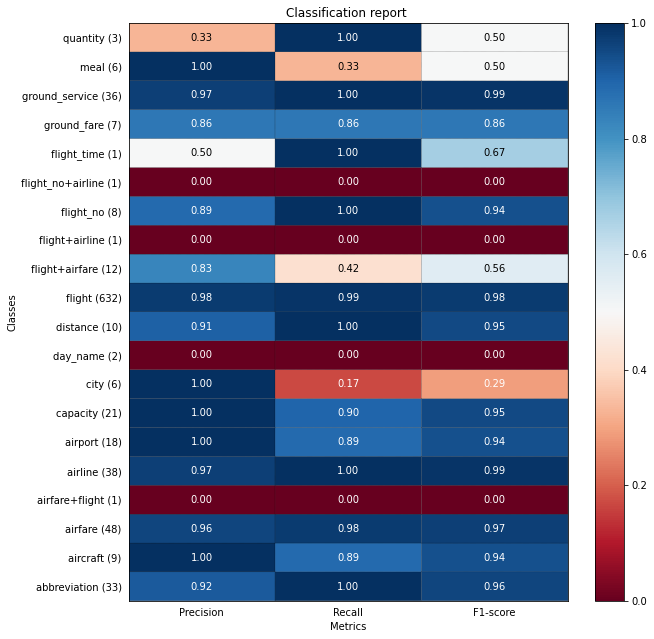

In [ ]:
#Intents
plot_classification_report(classification_report(cr_intents_ATIS[0], cr_intents_ATIS[1], zero_division=False))

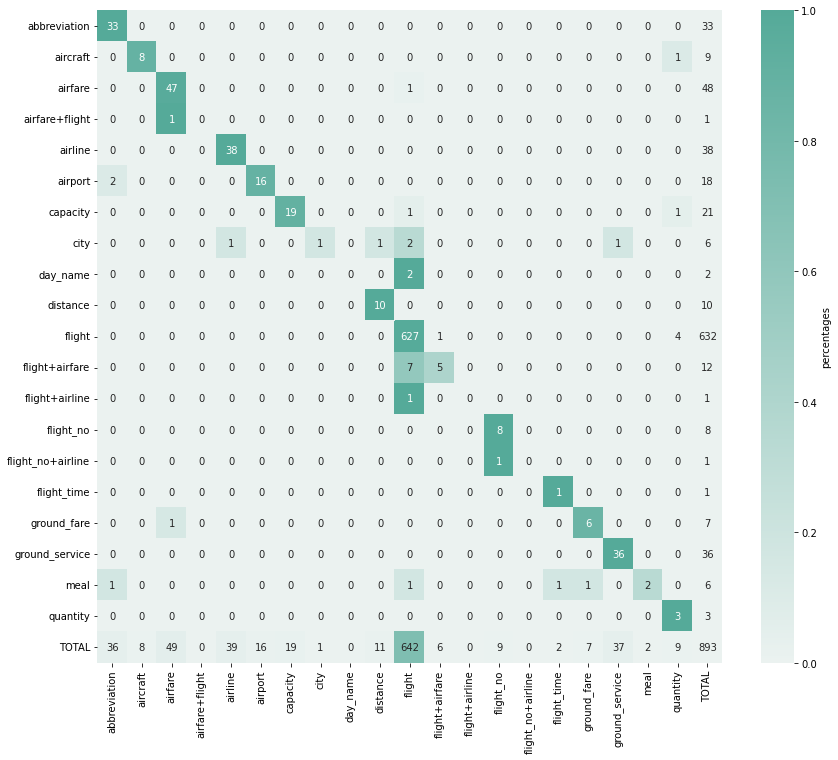

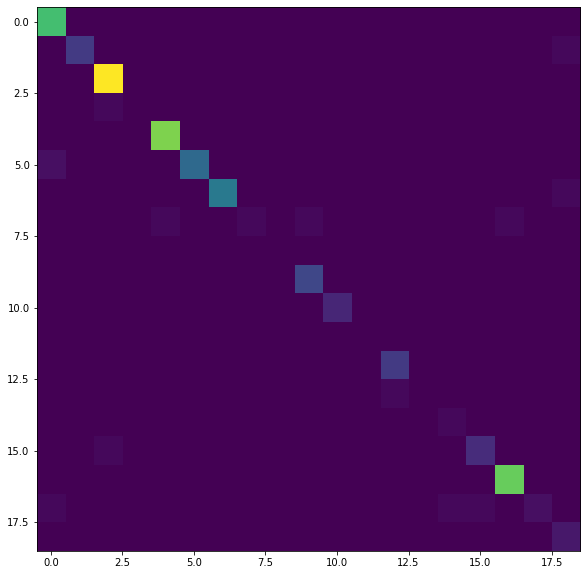

In [ ]:
labels = [line['intent'] for line in test_raw_ATIS]
classes = np.unique(labels)
size = (14,12)
plot_confusion_matrix(cr_intents_ATIS, classes, size)

plt.figure(figsize = (10,10))
classes = np.delete(classes, np.where(classes == 'flight'))
plt.imshow(confusion_matrix(cr_intents_ATIS[0], cr_intents_ATIS[1], labels=classes))
plt.show()

In [ ]:
#Slots
slots_table = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_ATIS.items(), key=lambda x: x[1]['f'], reverse = True)}, orient='index')
slots_table.round(decimals=2)

,p,r,f,s
toloc.country_name,1.0,1.0,1.0,1
depart_time.start_time,1.0,1.0,1.0,3
flight_days,1.0,1.0,1.0,10
depart_date.year,1.0,1.0,1.0,3
fromloc.state_code,1.0,1.0,1.0,23
...,...,...,...,...
return_date.day_name,1.0,0.0,0.0,2
flight,1.0,0.0,0.0,1
state_name,1.0,0.0,0.0,9
stoploc.airport_name,0.0,0.0,0.0,0


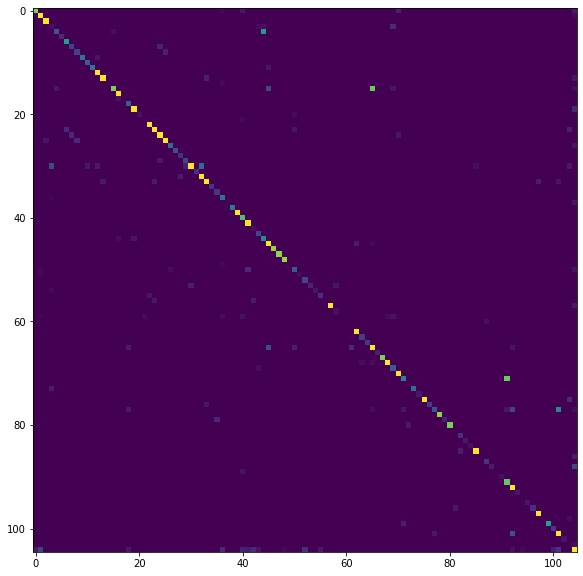

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_slots_ATIS[0], cr_slots_ATIS[1]), norm = mpl.colors.Normalize(vmin = 0, vmax = 255))
plt.show()

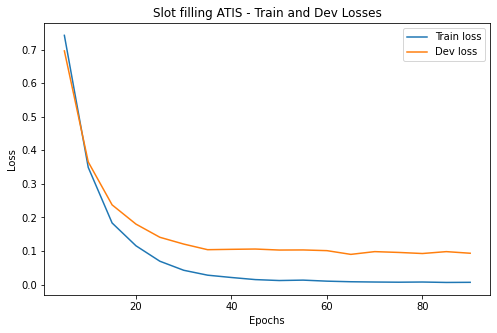

In [ ]:
title = 'Slot filling ATIS - Train and Dev Losses'
plot_losses(title, sampled_epochs_ATIS, losses_train_slots_ATIS, losses_dev_slots_ATIS)

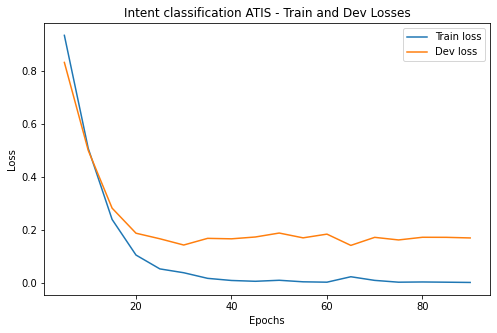

In [ ]:
title = 'Intent classification ATIS - Train and Dev Losses'
plot_losses(title, sampled_epochs_ATIS, losses_train_intents_ATIS, losses_dev_intents_ATIS)

####SNIPS

In [ ]:
sampled_epochs_SNIPS, losses_train_slots_SNIPS, losses_train_intents_SNIPS, losses_dev_slots_SNIPS, losses_dev_intents_SNIPS, cr_intents_SNIPS, cr_slots_SNIPS, results_test_SNIPS = training_setting(lang_SNIPS, train_loader_SNIPS, dev_loader_SNIPS, test_loader_SNIPS)

 50%|████▉     | 99/199 [35:26<35:47, 21.48s/it]



Slot F1:  0.8792111750205422
Intent Accuracy: 0.9742857142857143


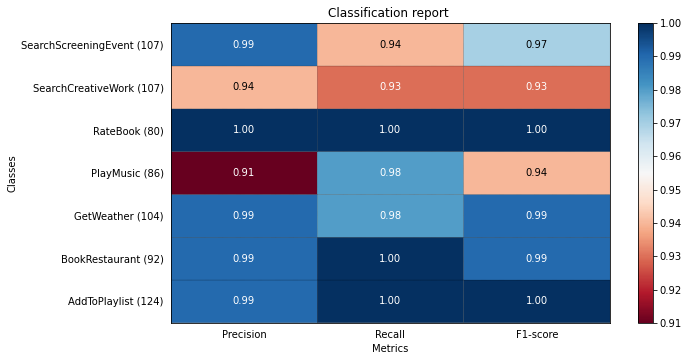

In [ ]:
#Intents
plot_classification_report(classification_report(cr_intents_SNIPS[0], cr_intents_SNIPS[1], zero_division=False))

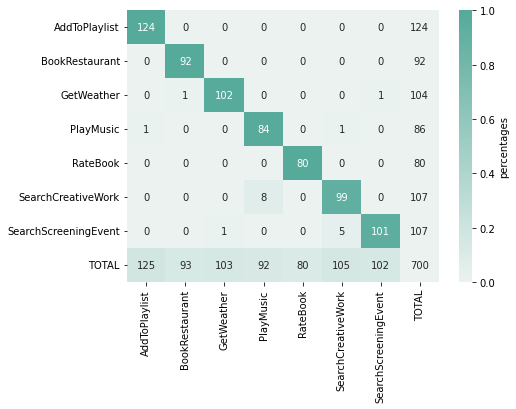

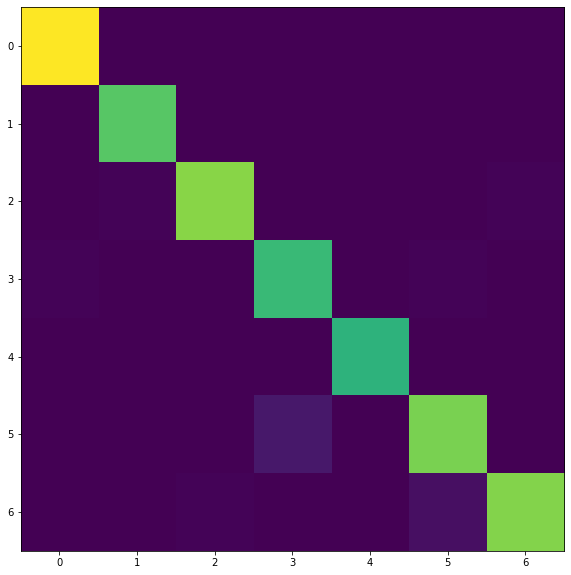

In [ ]:
labels = [line['intent'] for line in test_raw_SNIPS]
classes = np.unique(labels)
size = (7, 5)
plot_confusion_matrix(cr_intents_SNIPS, classes, size)

plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_intents_SNIPS[0], cr_intents_SNIPS[1], labels=classes))
plt.show()

In [ ]:
#Slots
slots_table = pd.DataFrame().from_dict({k: v for k, v in sorted(results_test_SNIPS.items(), key=lambda x: x[1]['f'], reverse = True)}, orient='index')
slots_table.round(decimals=2)

,p,r,f,s
playlist_owner,1.00,1.00,1.00,70
movie_type,1.00,1.00,1.00,33
best_rating,1.00,0.98,0.99,43
rating_unit,0.98,1.00,0.99,40
rating_value,1.00,0.98,0.99,80
condition_description,0.97,1.00,0.98,28
condition_temperature,1.00,0.96,0.98,23
restaurant_type,0.96,1.00,0.98,65
sort,0.94,1.00,0.97,32
music_item,0.94,1.00,0.97,104


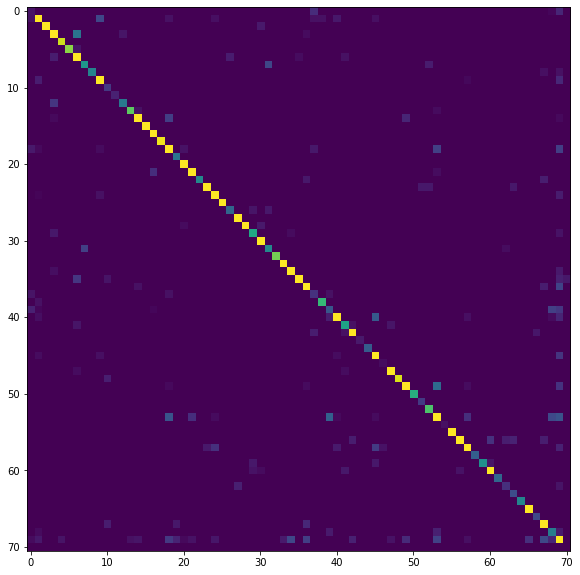

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(confusion_matrix(cr_slots_SNIPS[0], cr_slots_SNIPS[1]), norm = mpl.colors.Normalize(vmin = 0, vmax = 255))
plt.show()

##### Plot of the train and valid losses - Third model


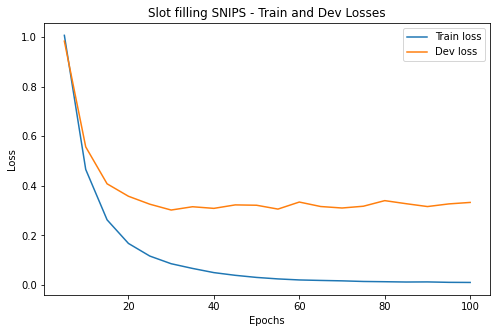

In [ ]:
title = 'Slot filling SNIPS - Train and Dev Losses'
plot_losses(title, sampled_epochs_SNIPS, losses_train_slots_SNIPS, losses_dev_slots_SNIPS)

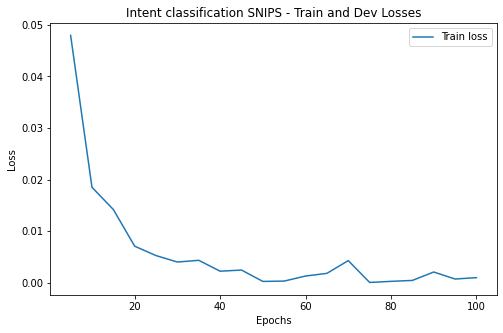

In [ ]:
title = 'Intent classification SNIPS - Train and Dev Losses'
plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
plt.title(title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(sampled_epochs_SNIPS, losses_train_intents_SNIPS, label='Train loss')
plt.legend()
plt.show()